# *CELEBAL TECHNOLOGIES*
## *PROJECT: Air Quality Prediction for Urban Areas*
### *GROUP: 1*
###### 1. Pranav Chouhan
######  2. Saroj Choudary
######  3. Pushpita Jana
######  4. Mohammad Sami Khan
######  5. Radhika Thapar
######  6. Anurag Kunungo

## 1. Introduction

This kernel benchmarks classic **Machine Learning models for Text Classification**. Words are vectorized using TF-IDF and both character and word level n-grams of different sizes. The models implemented are Logistic Regression, Support Vector Machines and Naive Bayes. 

The notebook follows these steps:

 - **Load train and test datasets**
 - **EDA**
 - **Feature extraction/vectorization of corpus with TD-IDF**
 - **Training of multi-class categorization ML models for toxicity levels and type**
 - **Models hyperparameter tuning**
 - **Performance metrics and ML models comparison**

## 2. Import Libraries and Datasets

In [1]:
import pandas as pd, numpy as np
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
from scipy import sparse
import gc, sys, warnings
warnings.filterwarnings('ignore')
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV


In [2]:
test_df = pd.read_csv('test.csv')
train_df = pd.read_csv('train.csv')
sample_input = pd.read_csv('sample_submission.csv')
test_labels = pd.read_csv('test_labels.csv')

In [3]:
train_df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             159571 non-null  object
 1   comment_text   159571 non-null  object
 2   toxic          159571 non-null  int64 
 3   severe_toxic   159571 non-null  int64 
 4   obscene        159571 non-null  int64 
 5   threat         159571 non-null  int64 
 6   insult         159571 non-null  int64 
 7   identity_hate  159571 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 9.7+ MB


In [5]:
train_df.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [6]:
train_df.isnull().sum()

id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64

In [7]:
categories = list(train_df.columns.values)
categories = categories[2:]
print(categories)

['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']


In [8]:
# Calculating Number of Comments in each Category 
counts = []
for category in categories:
    counts.append((category, train_df[category].sum()))
df_stats = pd.DataFrame(counts, columns=['category', 'number of comments'])
df_stats

,category,number of comments
0,toxic,15294
1,severe_toxic,1595
2,obscene,8449
3,threat,478
4,insult,7877
5,identity_hate,1405


# 3. EDA

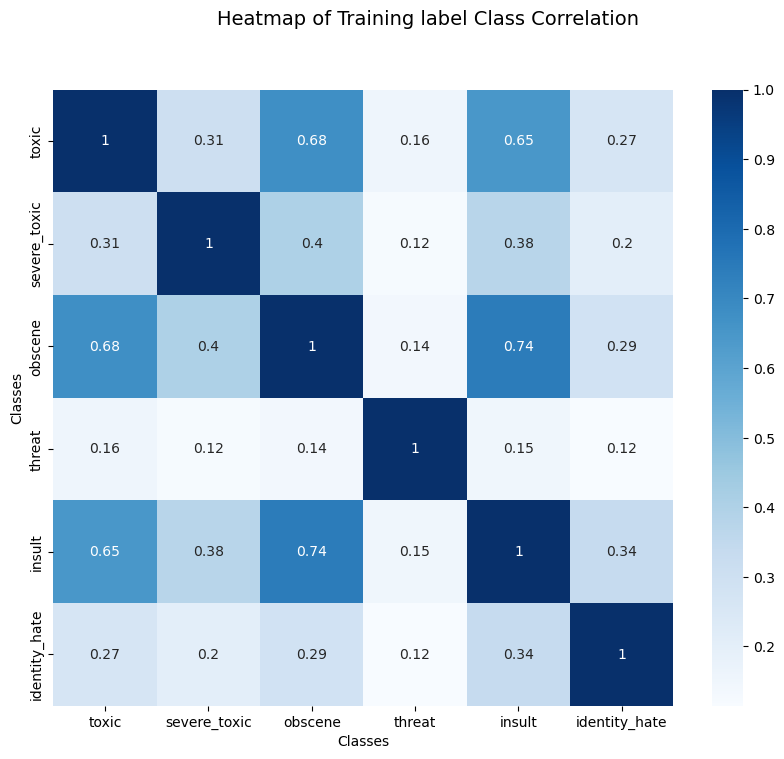

In [9]:
fig = plt.figure(figsize = (10,8))
sns.heatmap(train_df.corr(), annot=True,cmap="Blues")
plt.suptitle('Heatmap of Training label Class Correlation',size = 14)
plt.xlabel("Classes")
plt.ylabel("Classes")
plt.show()

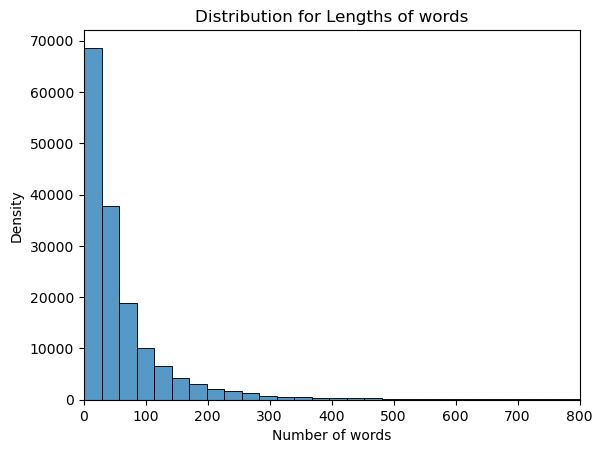

In [10]:
# Checking Comment Lenght
comment_length = train_df['comment_text'].str.split().apply(len)
sns.histplot(comment_length,bins=50,)
plt.title("Distribution for Lengths of words")
plt.xlabel("Number of words")
plt.ylabel("Density")
plt.xlim(0, 800)
plt.show()

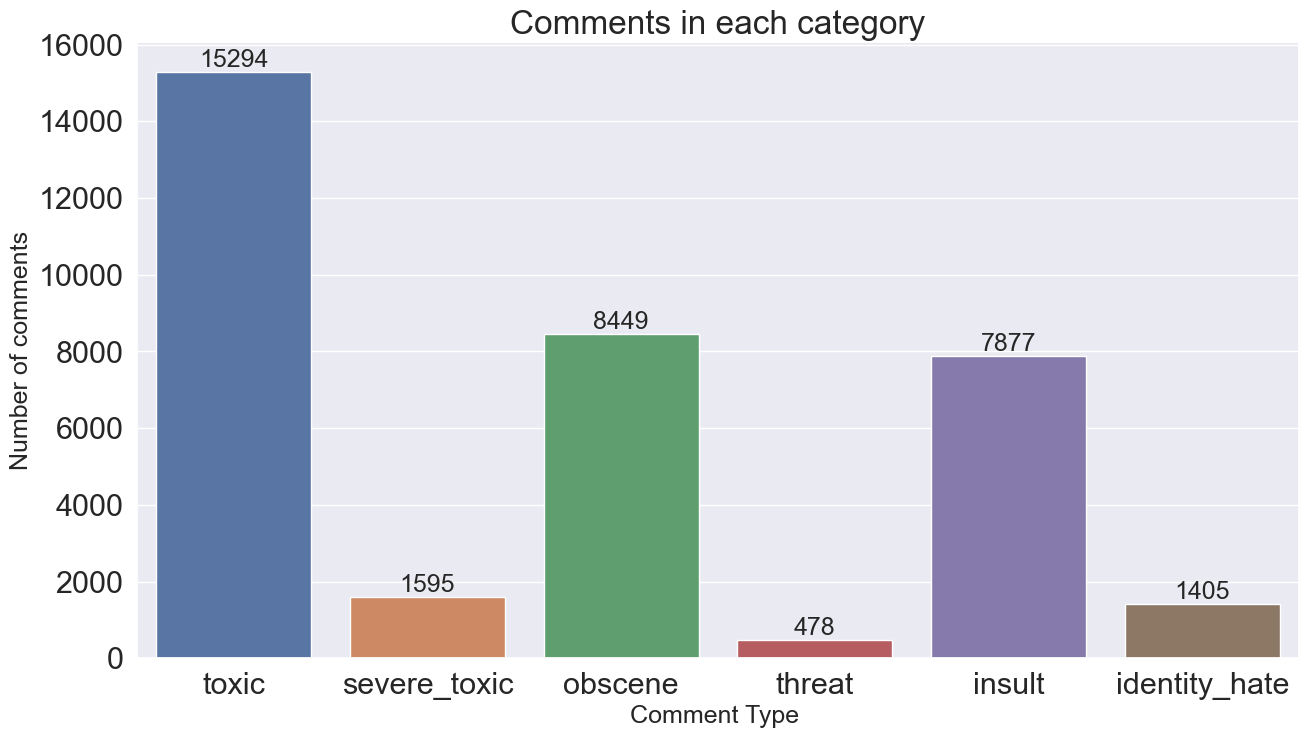

In [11]:
sns.set(font_scale = 2)
plt.figure(figsize=(15,8))

ax= sns.barplot(x=categories, y=train_df.iloc[:,2:].sum().values)

plt.title("Comments in each category", fontsize=24)
plt.ylabel('Number of comments', fontsize=18)
plt.xlabel('Comment Type ', fontsize=18)

#adding the text labels
rects = ax.patches
labels = train_df.iloc[:,2:].sum().values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom', fontsize=18)

plt.show()

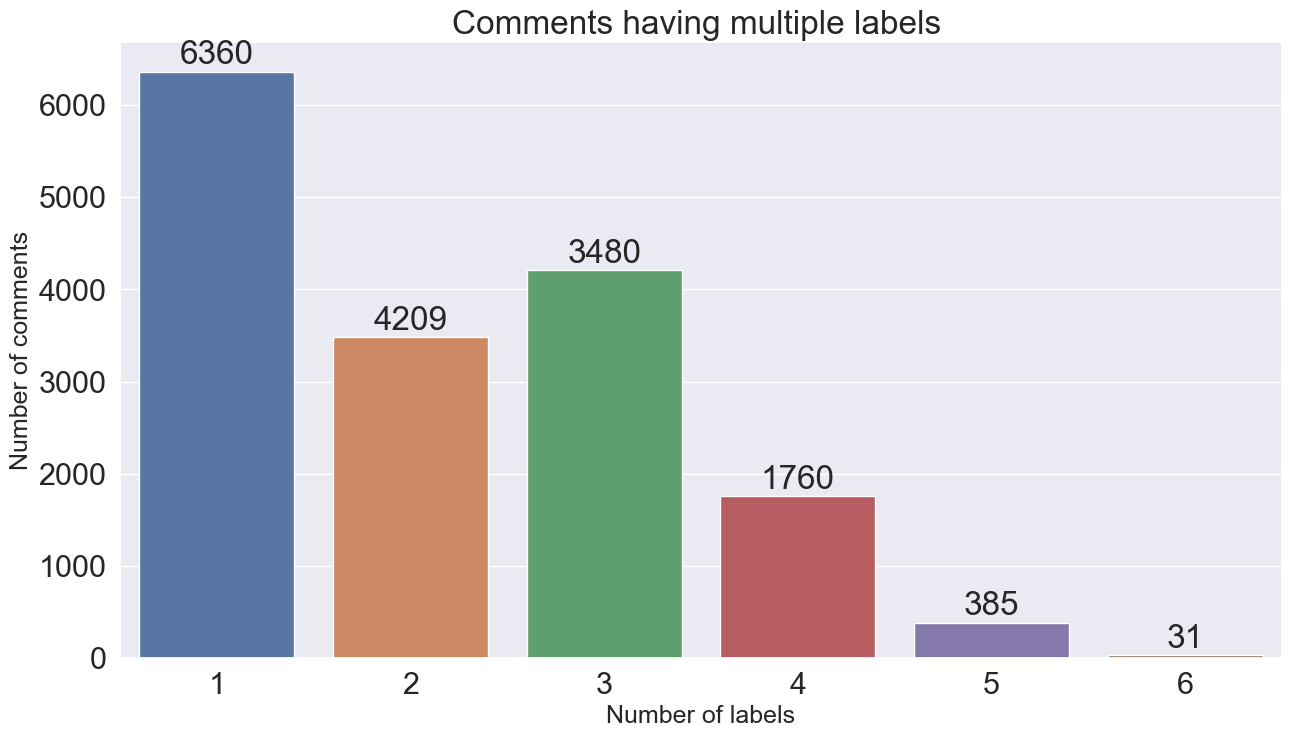

In [12]:
rowSums = train_df.iloc[:,2:].sum(axis=1)
multiLabel_counts = rowSums.value_counts()
multiLabel_counts = multiLabel_counts.iloc[1:]

sns.set(font_scale = 2)
plt.figure(figsize=(15,8))

ax = sns.barplot(x=multiLabel_counts.index, y=multiLabel_counts.values)

plt.title("Comments having multiple labels ")
plt.ylabel('Number of comments', fontsize=18)
plt.xlabel('Number of labels', fontsize=18)

#adding the text labels
rects = ax.patches
labels = multiLabel_counts.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()

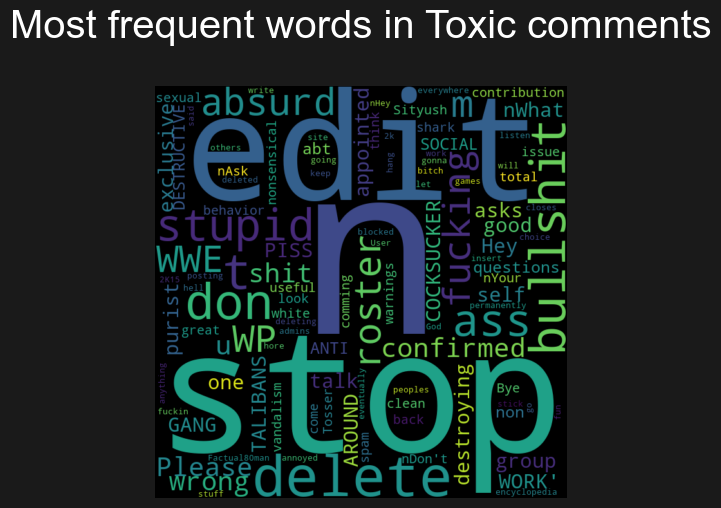

In [13]:
def word_plot(column,text):
    
    comments = train_df['comment_text'].loc[column == 1].values     # sort by toxicity
    
    word_cloud = WordCloud( width = 640, height = 640, background_color = 'black',
                stopwords = STOPWORDS).generate(str(comments))     # stopwords are a,an,the
    
    fig = plt.figure( figsize = (8, 5), facecolor = 'k', edgecolor = 'k')
    plt.subplot()
    plt.imshow(word_cloud, interpolation = 'bilinear')
    plt.suptitle("Most frequent words in " +  text , y = 1.06,color = "white")
    plt.tight_layout(pad = 0)
    plt.axis('off')
    plt.show()
    
word_plot(train_df['toxic'], "Toxic comments")

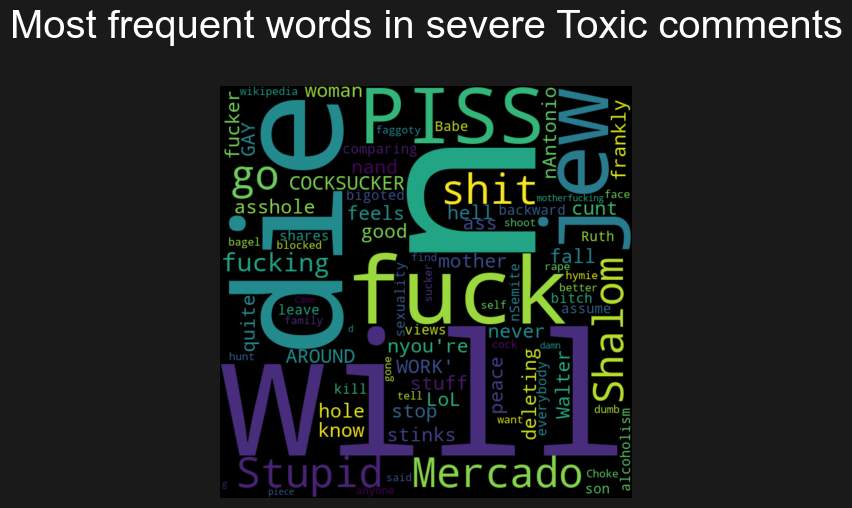

In [14]:
word_plot(train_df['severe_toxic'],"severe Toxic comments")


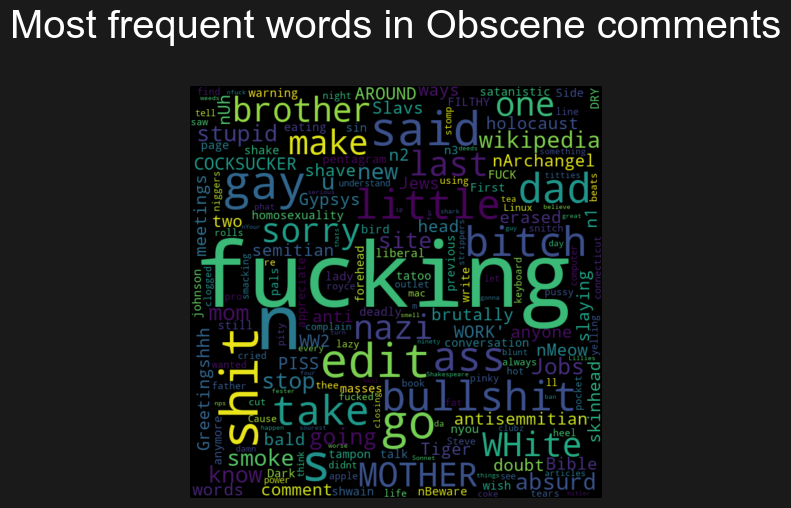

In [15]:
word_plot(train_df['obscene'],"Obscene comments")


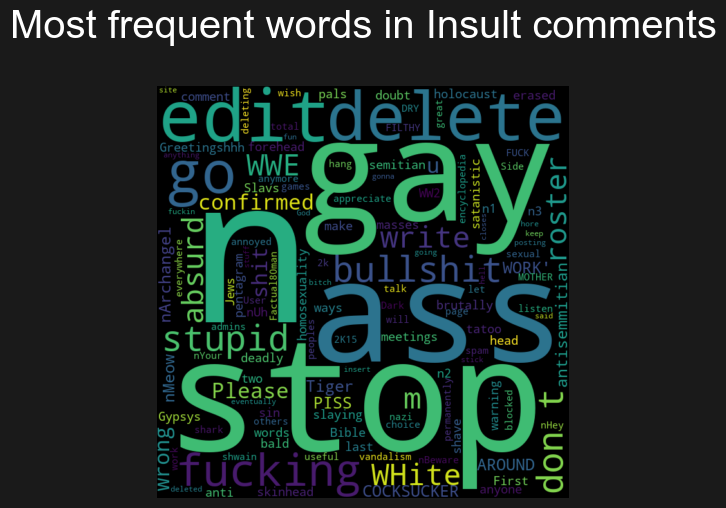

In [16]:
word_plot(train_df['insult'],"Insult comments")


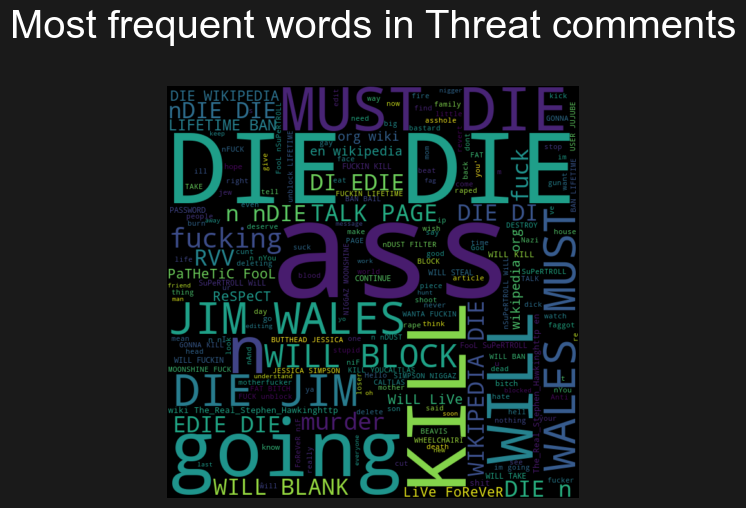

In [17]:
word_plot(train_df['threat'],"Threat comments")

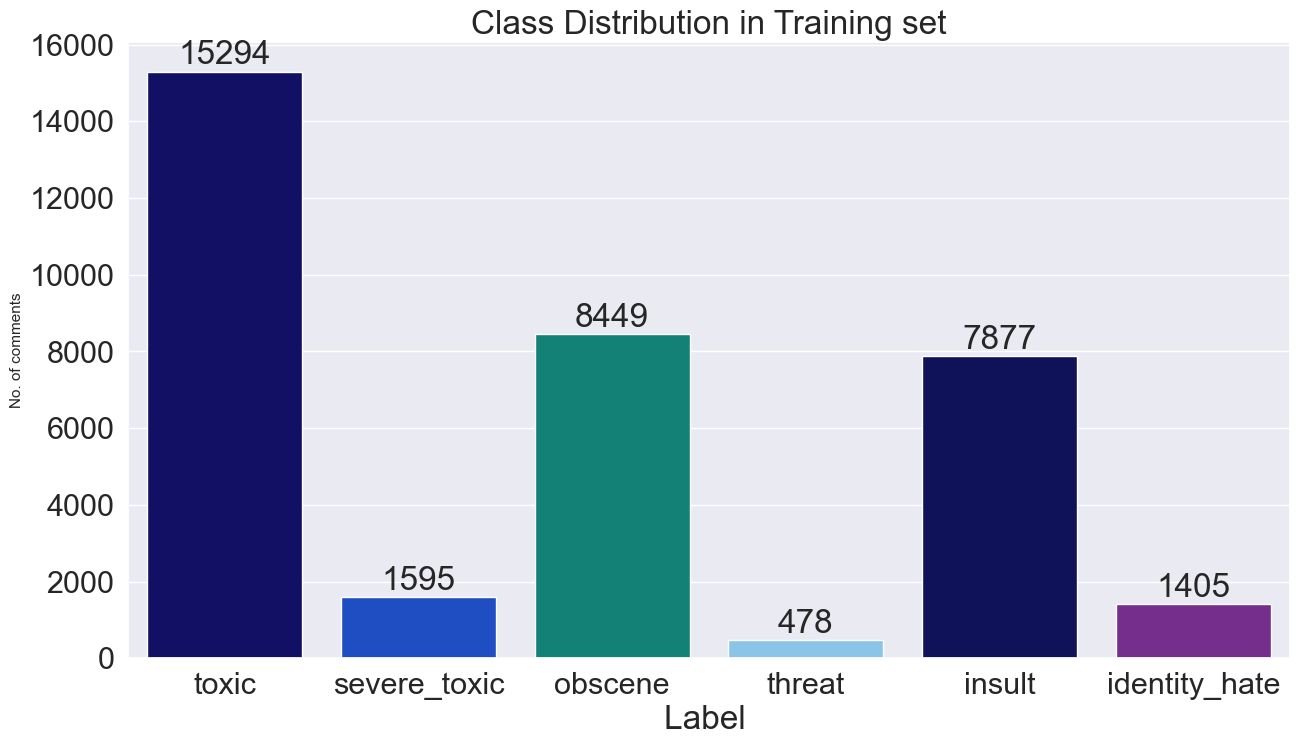

In [18]:
colors_ = ["deep blue","blue", "teal", "lightblue","darkblue","purple"]

palette= sns.xkcd_palette(colors_)

x = train_df.iloc[:,2:].sum()

plt.figure(figsize=(15,8))

ax= sns.barplot(x=x.index,y=x.values,palette=palette)
plt.title("Class Distribution in Training set")
plt.xlabel('Label ')
plt.ylabel('No. of comments', fontsize=11)

patch = ax.patches
labels = x.values
for rect, label in zip(patch, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 10, label, va='bottom',ha='center')

plt.show()

In [19]:
count_word = train_df["comment_text"].apply(lambda x: len(str(x).split()))
#Unique word count
count_unique_word = train_df["comment_text"].apply(lambda x: len(set(str(x).split())))
unique_percent = count_unique_word*100/count_word
unique_percent

0          95.348837
1         100.000000
2          92.857143
3          72.566372
4         100.000000
             ...    
159566     93.617021
159567    100.000000
159568    100.000000
159569     92.000000
159570     88.888889
Name: comment_text, Length: 159571, dtype: float64

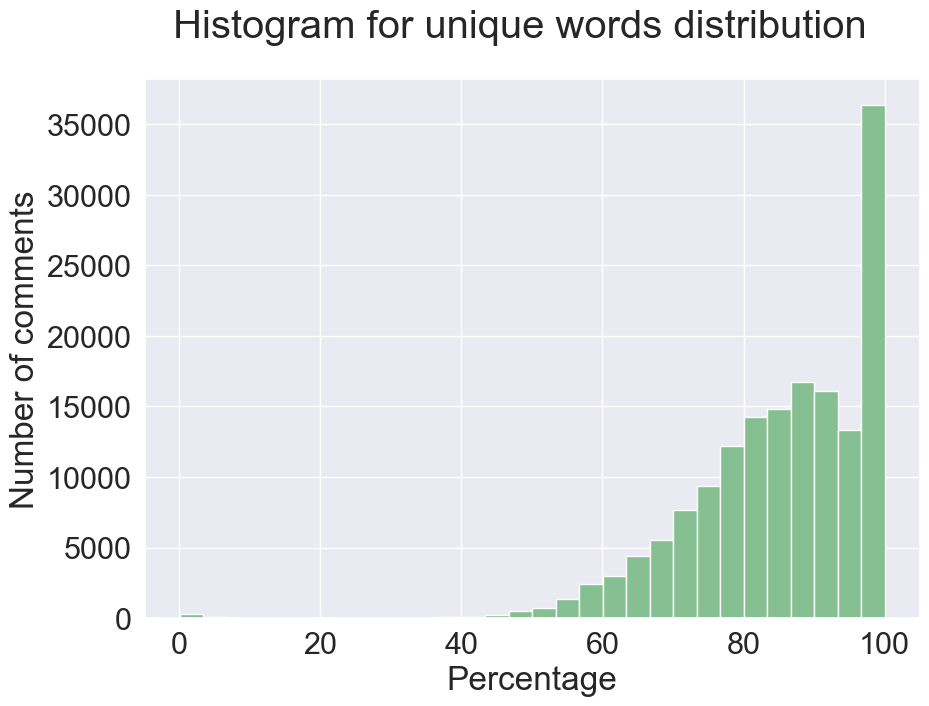

In [20]:
# plot unique words distribution for comments
unique_percent.hist(bins=30, figsize=(10,7), color='#86bf91')
plt.suptitle("Histogram for unique words distribution")
plt.xlabel("Percentage")
plt.ylabel("Number of comments")
plt.show()

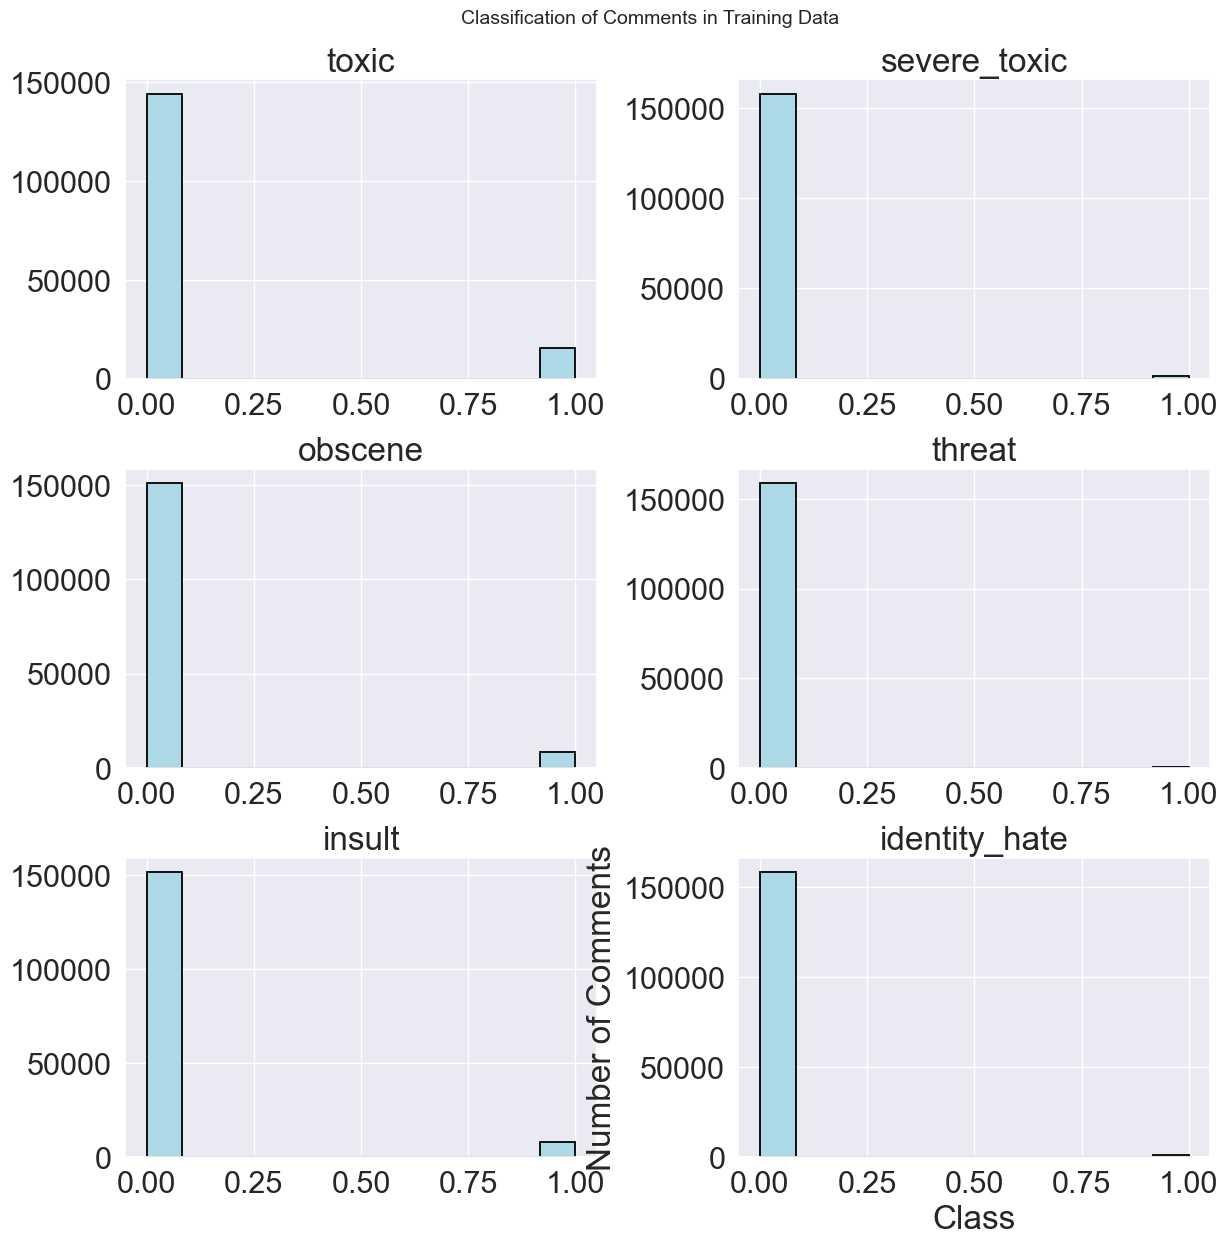

In [21]:
fig = plt.figure(figsize = (14,14))
ax = fig.gca()
train_df.hist(ax = ax,edgecolor = 'black',facecolor = 'lightblue',bins = 12,linewidth = 1.3)
plt.suptitle('Classification of Comments in Training Data',y = 0.93,size = 14)
plt.xlabel("Class")
plt.ylabel("Number of Comments")
plt.show()

# It can be observed that there is a high imbalance among the classes
# Most of the values are zero for all classes

## 4. Training Data Pre-processing

In [22]:
TEXT = 'comment_text'
labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
# add label to mark non-toxic comments
train_df['non-toxic'] = 1 - train_df[labels].max(axis=1)
# replace na values with placeholder
train_df[TEXT].fillna("unknown", inplace=True)
test_df[TEXT].fillna("unknown", inplace=True)

## 5. Feature extraction: TD-IDF vectorization


### Generate word n-grams from training data vocabulary

In [23]:
# tokenizing and filtering of stopwords is included in CountVectorizer
# apply sublinear tf scaling, i.e. replace tf with 1 + log(tf)
# max_df = 0.9, i.e. ignore words appearing in > 90% documents
vec_words = TfidfVectorizer(stop_words='english', analyzer='word',
                            min_df=3, max_df=0.9, strip_accents='unicode', sublinear_tf=1)
# ngram_range=(1,2) # ideally added, increases training time

# create vocabulary based on training data
vec_words.fit_transform(train_df[TEXT])
# vectorize train and test data for scoring
train_vec_words = vec_words.transform(train_df[TEXT])
test_vec_words = vec_words.transform(test_df[TEXT])

### Concatenate n-grams into a single Feature Matrix

In [24]:
features, test_features = train_vec_words, test_vec_words
labels = ['toxic', 'severe_toxic', 'obscene', 'threat','insult', 'identity_hate']
y = train_df[labels]

## 6. Machine Learning Models
We will train a model per toxicity type i.e. 6 models per algorithm. To keep the notebook concise, all Confusion Matrices and ROC plots will show the `threat` class classifier only. Comparison for performance in all classes is assessed via the AUC value.

### 6.1 Logistic Regression

In [25]:
# create an array to store all the predictions
predictions = np.zeros((test_features.shape[0],y.shape[1]))
# fit a model per class
for i, label in enumerate(labels):
    lr = LogisticRegression(C=2, random_state = i, class_weight = 'balanced')
    print('Building {} model for column:{''}'.format(i, label)) 
    lr.fit(features, y[label])
    predictions[:, i] = lr.predict_proba(test_features)[:, 1]

Building 0 model for column:toxic
Building 1 model for column:severe_toxic
Building 2 model for column:obscene
Building 3 model for column:threat
Building 4 model for column:insult
Building 5 model for column:identity_hate


In [26]:
label = 'threat'
pred_lr =  lr.predict(features)
# show confussion matrix for toxicity classification
print(confusion_matrix(y[label], pred_lr))
print(classification_report(y[label], pred_lr))

[[155315   3778]
 [   304    174]]
              precision    recall  f1-score   support

           0       1.00      0.98      0.99    159093
           1       0.04      0.36      0.08       478

    accuracy                           0.97    159571
   macro avg       0.52      0.67      0.53    159571
weighted avg       1.00      0.97      0.98    159571



Text(0.5, 1.0, 'ROC Curve')

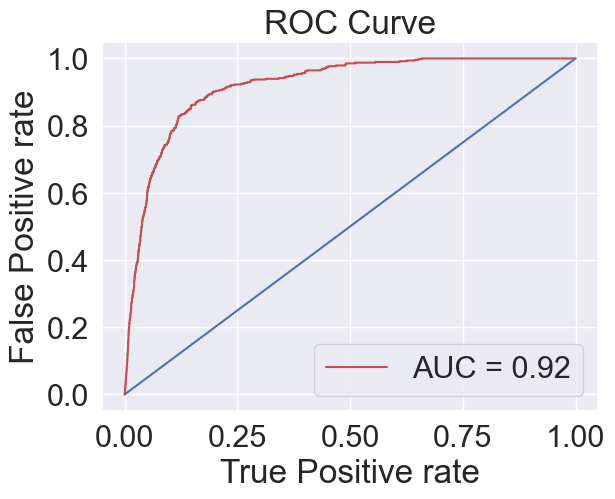

In [27]:
pred_prob_lr = lr.predict_proba(features)[:,1]
frp, trp, threshold = roc_curve(y[label], pred_prob_lr)
auc_val = auc(frp, trp)

plt.plot([0,1], [0,1], color='b')
plt.plot(frp, trp, color='r', label= 'AUC = %.2f'%auc_val)
plt.legend(loc='lower right')
plt.xlabel('True Positive rate')
plt.ylabel('False Positive rate')
plt.title('ROC Curve')

### 6.2 Support Vector Machines


In [28]:
pred = np.zeros((test_features.shape[0],y.shape[1]))
for i, label in enumerate(labels):
    sgdc = SGDClassifier(loss='squared_loss', penalty='l2',
                        alpha=1e-3, random_state=42,
                        max_iter=5, tol=None)
    print('Building {} model for column:{''}'.format(i, label)) 
    sgdc.fit(features, y[label])
    pred[:, i] = sgdc.decision_function(test_features)

Building 0 model for column:toxic
Building 1 model for column:severe_toxic
Building 2 model for column:obscene
Building 3 model for column:threat
Building 4 model for column:insult
Building 5 model for column:identity_hate


In [29]:
pred_sgdc = sgdc.predict(features)
# show confussion matrix for toxicity classification
print(confusion_matrix(y[label], pred_sgdc))
print(classification_report(y[label], pred_sgdc))

[[158166      0]
 [  1405      0]]
              precision    recall  f1-score   support

           0       0.99      1.00      1.00    158166
           1       0.00      0.00      0.00      1405

    accuracy                           0.99    159571
   macro avg       0.50      0.50      0.50    159571
weighted avg       0.98      0.99      0.99    159571



Text(0.5, 1.0, 'ROC Curve')

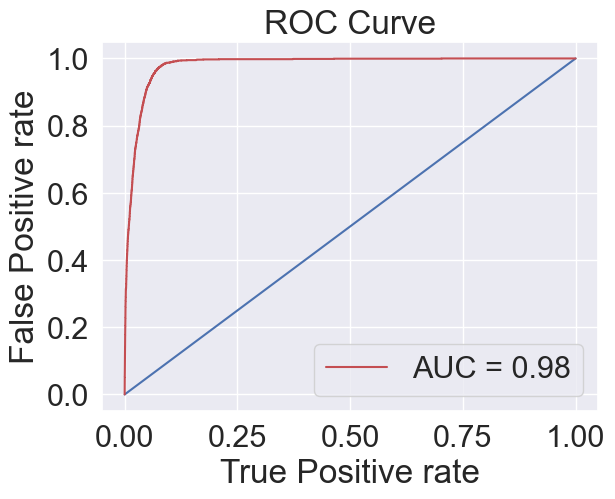

In [30]:
pred_prob_sgdc = sgdc.decision_function(features)
frp, trp, threshold = roc_curve(y[label], pred_prob_sgdc)
auc_val = auc(frp, trp)

plt.plot([0,1], [0,1], color='b')
plt.plot(frp, trp, color='r', label= 'AUC = %.2f'%auc_val)
plt.legend(loc='lower right')
plt.xlabel('True Positive rate')
plt.ylabel('False Positive rate')
plt.title('ROC Curve')

### 6.3 Naive Bayes

Several variants of Naive Bayes classifier exist. We will fit the multinomial variant, which is most suitable for word counts:

In [31]:
pred = np.zeros((test_features.shape[0],y.shape[1]))
for i, label in enumerate(labels):
    nb = MultinomialNB(alpha = 0.0001)
    print('Building {} model for column:{''}'.format(i, label)) 
    nb.fit(features, y[label])
    pred[:, i] = nb.predict_proba(test_features)[:, 1]

Building 0 model for column:toxic
Building 1 model for column:severe_toxic
Building 2 model for column:obscene
Building 3 model for column:threat
Building 4 model for column:insult
Building 5 model for column:identity_hate


In [32]:
pred_nb =  nb.predict(features)
print(confusion_matrix(y[label], pred_nb))
print(classification_report(y[label], pred_nb))

[[157751    415]
 [   461    944]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    158166
           1       0.69      0.67      0.68      1405

    accuracy                           0.99    159571
   macro avg       0.85      0.83      0.84    159571
weighted avg       0.99      0.99      0.99    159571



Text(0.5, 1.0, 'ROC Curve')

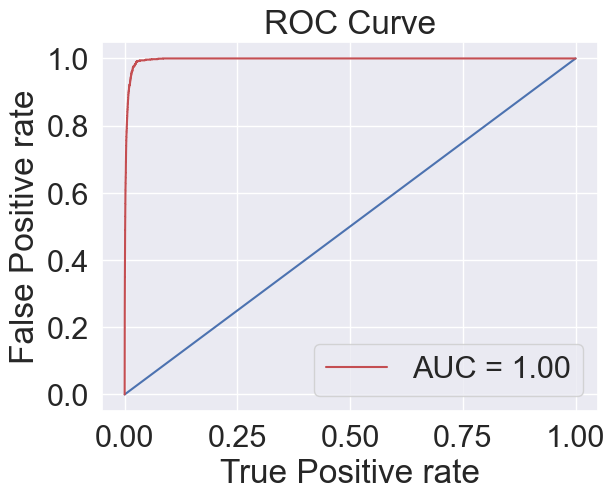

In [33]:
pred_prob_nb = nb.predict_proba(features)[:,1]
frp, trp, threshold = roc_curve(y[label], pred_prob_nb)
auc_val = auc(frp, trp)

plt.plot([0,1], [0,1], color='b')
plt.plot(frp, trp, color='r', label= 'AUC = %.2f'%auc_val)
plt.legend(loc='lower right')
plt.xlabel('True Positive rate')
plt.ylabel('False Positive rate')
plt.title('ROC Curve')

# Comparing Models

In [34]:
print("-"*20,"Logistic Regression","-"*20)
print(classification_report(y[label], pred_lr))
print("-"*20,"Support Vector Machines","-"*20)
print(classification_report(y[label], pred_sgdc))
print("-"*20,"Naive Bayes","-"*20)
print(classification_report(y[label], pred_nb))

-------------------- Logistic Regression --------------------
              precision    recall  f1-score   support

           0       1.00      0.98      0.99    158166
           1       0.36      1.00      0.52      1405

    accuracy                           0.98    159571
   macro avg       0.68      0.99      0.76    159571
weighted avg       0.99      0.98      0.99    159571

-------------------- Support Vector Machines --------------------
              precision    recall  f1-score   support

           0       0.99      1.00      1.00    158166
           1       0.00      0.00      0.00      1405

    accuracy                           0.99    159571
   macro avg       0.50      0.50      0.50    159571
weighted avg       0.98      0.99      0.99    159571

-------------------- Naive Bayes --------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    158166
           1       0.69      0.67      0.68      1405



## 6. Pipelining and Parameter Tuning

#### Multinomial Naive Bayes Tuning

In [35]:
toxic_clf = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english', analyzer='word',
                              min_df=3, max_df=0.9, strip_accents='unicode', sublinear_tf=1)),
    ('clf', MultinomialNB())
])

Using Pipelines also comes in handy when **tuning the hyperparameters**. We can run an exhaustive search of the best parameters on all stages of the pipeline. In this case, we'll use `GridSearch`: 

In [36]:
parameters = {
    'clf__alpha': (0, 0.25, 0.5, 0.75, 1)
}

In [37]:
# n_jobs = -1 detects how many cores are installed and uses them all
opt_toxic_clf = GridSearchCV(toxic_clf, parameters, cv=5, n_jobs=-1)
opt_toxic_clf = opt_toxic_clf.fit(train_df[TEXT], y[label])

In [38]:
print(opt_toxic_clf.best_score_)
for p in sorted(parameters.keys()):
    print("%s: %r" % (p, opt_toxic_clf.best_params_[p]))
print(opt_toxic_clf.cv_results_)

0.9912828775666108
clf__alpha: 0.25
{'mean_fit_time': array([44.14574227, 30.6106638 , 25.7214325 , 24.79011798, 23.72250671]), 'std_fit_time': array([2.3824898 , 1.69997139, 2.71195624, 0.83376843, 3.57452242]), 'mean_score_time': array([5.53847232, 9.51432095, 5.93755627, 6.01338472, 4.33992386]), 'std_score_time': array([1.03965654, 1.85393544, 0.66327784, 0.33823434, 1.0167845 ]), 'param_clf__alpha': masked_array(data=[0, 0.25, 0.5, 0.75, 1],
             mask=[False, False, False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'clf__alpha': 0}, {'clf__alpha': 0.25}, {'clf__alpha': 0.5}, {'clf__alpha': 0.75}, {'clf__alpha': 1}], 'split0_test_score': array([0.99034937, 0.9912267 , 0.99116403, 0.99119536, 0.99119536]), 'split1_test_score': array([0.99103842, 0.99128909, 0.99116375, 0.99119509, 0.99116375]), 'split2_test_score': array([0.98987905, 0.99132042, 0.99122642, 0.99119509, 0.99122642]), 'split3_test_score': array([0.99091308, 0.99135176, 0.99119

The best choice for the `alpha` smoothing factor is `0.25`.

#### SVM Tuning

In [39]:
toxic_clf = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english', analyzer='word',
                              min_df=3, max_df=0.9, strip_accents='unicode', sublinear_tf=1)),
    ('clf', SGDClassifier())
])
parameters = {
    'clf__alpha': (0.0001, 0.001, 0.01, 0.1)
}
# n_jobs = -1 detects how many cores are installed and uses them all
opt_toxic_clf = GridSearchCV(toxic_clf, parameters, cv=5, n_jobs=-1)
opt_toxic_clf = opt_toxic_clf.fit(train_df[TEXT], y[label])

In [40]:
print(opt_toxic_clf.best_score_)
for p in sorted(parameters.keys()):
    print("%s: %r" % (p, opt_toxic_clf.best_params_[p]))
print(opt_toxic_clf.cv_results_)

0.9913831458626603
clf__alpha: 0.0001
{'mean_fit_time': array([23.13361506, 25.28338308, 24.21694198, 22.54299922]), 'std_fit_time': array([1.05543407, 1.61971901, 2.05598568, 0.4428187 ]), 'mean_score_time': array([6.5538682 , 6.77287898, 5.3647706 , 3.81395879]), 'std_score_time': array([0.66042508, 0.55187987, 0.22320366, 0.30950011]), 'param_clf__alpha': masked_array(data=[0.0001, 0.001, 0.01, 0.1],
             mask=[False, False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'clf__alpha': 0.0001}, {'clf__alpha': 0.001}, {'clf__alpha': 0.01}, {'clf__alpha': 0.1}], 'split0_test_score': array([0.9914147 , 0.99119536, 0.99119536, 0.99119536]), 'split1_test_score': array([0.99128909, 0.99119509, 0.99119509, 0.99119509]), 'split2_test_score': array([0.99144576, 0.99119509, 0.99119509, 0.99119509]), 'split3_test_score': array([0.99150843, 0.99119509, 0.99119509, 0.99119509]), 'split4_test_score': array([0.99125776, 0.99119509, 0.99119509, 0.99119509]), 'me

The best choice for the `alpha` constant that multiplies the regularization term is `0.0001`.

## 7. Conclusions

Let's visualize the ROC/AUC for all classifiers and toxicity types. We'll define a function to speed up the process:

In [41]:
def str_to_class(classname):
    return getattr(sys.modules[__name__], classname)

def compare_clfs(label):
    plt.figure(0).clf()
    # plot reference AUC 0.5 line
    plt.plot([0,1], [0,1], color='k')
    
    # compute ROC for each classifier
    classifiers = {'lr':'g', 'sgdc':'b', 'nb':'r'}
    for c in classifiers.keys():
        model = str_to_class(c)
        if c == 'sgdc':
            pred_prob = model.decision_function(features)
        else:
            pred_prob = model.predict_proba(features)[:,1]
        frp, trp, threshold = roc_curve(y[label], pred_prob)
        auc_val = auc(frp, trp)
        plt.plot(frp, trp, color=classifiers[c], label= f'{c.upper()} AUC = %.2f'%auc_val)

    plt.legend(loc=0)
    plt.xlabel('True Positive rate')
    plt.ylabel('False Positive rate')
    plt.title(f'ROC Curve for {label.capitalize()} Class Classifiers')
    plt.show()

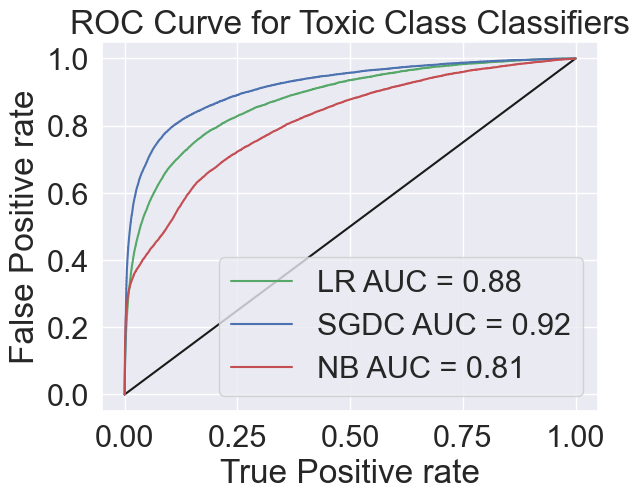

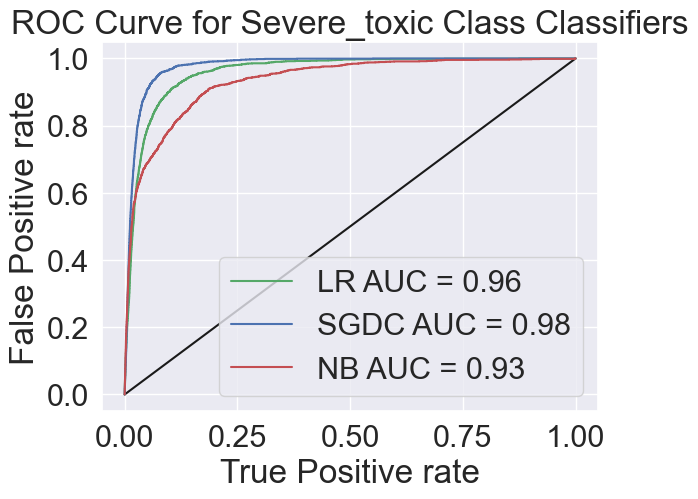

In [42]:
compare_clfs('toxic')
compare_clfs('severe_toxic')

Interestingly, severly toxic comments are better identified by all classifiers. For both levels of toxicity, LR yields the best results.

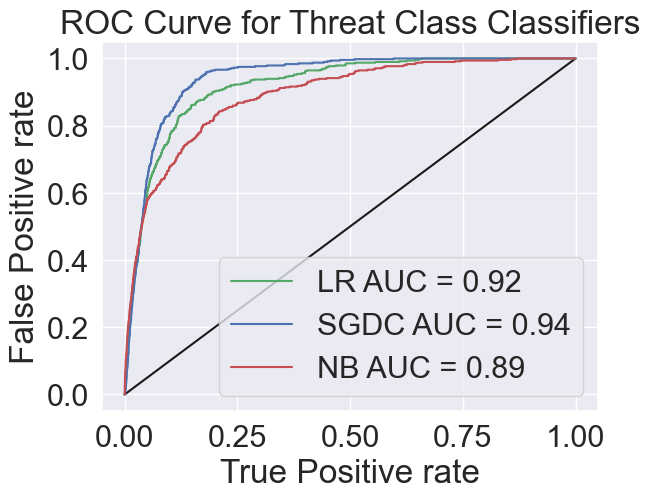

In [43]:
compare_clfs('threat')

LR also yields the best results for Threat type classification. Let's see if LR is still the most performant model for other classes:

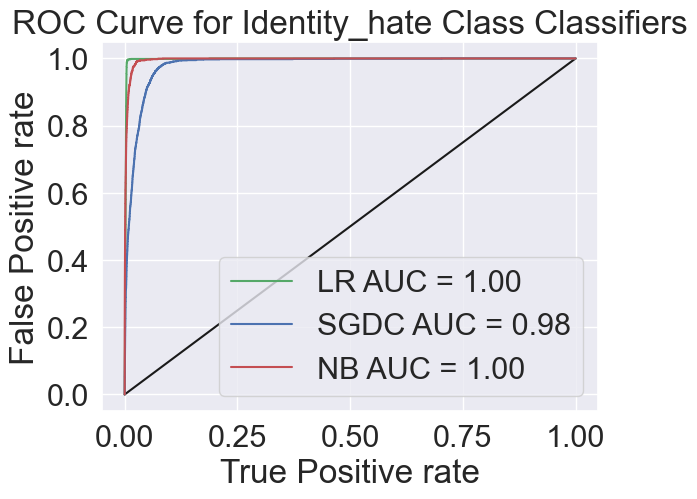

In [44]:
compare_clfs('identity_hate')

Identity hate comments are classified with near 100% accuracy by both LR and SVM classifiers.

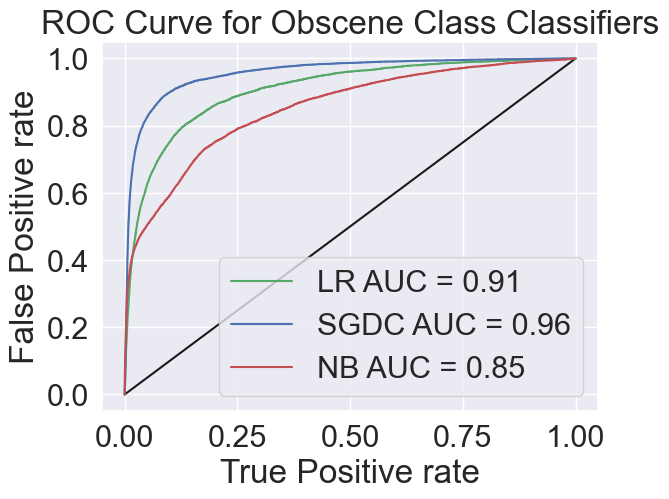

In [45]:
compare_clfs('obscene')

LR and SVM classifiers also show a consistent 

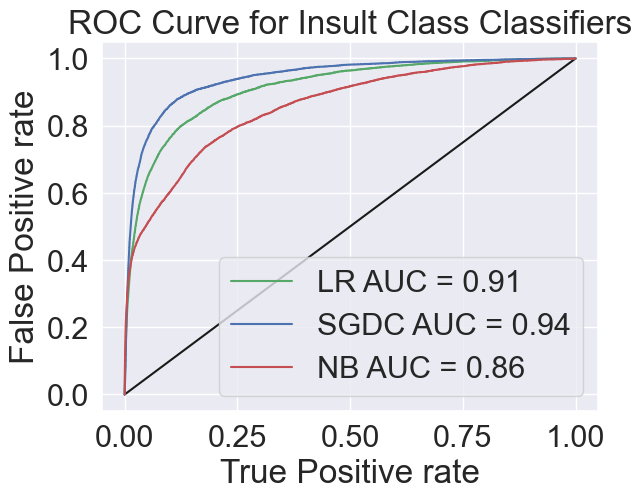

In [46]:
compare_clfs('insult')

With the default hyperparameters (see previous Kernel commit), Logistic Regression provided the best results for all classes. However, after tuning SVM and NB, the SVM model outperforms the other two in all toxicity types except `identity_hate`.

In [52]:
import pandas as pd
import numpy as np
import pickle
from sklearn.calibration import CalibratedClassifierCV


# Step 1: Load the models from pickle files for each label
labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
models = {}
for label in labels:
    with open(f'{label}_model.pkl', 'rb') as file:
        models[label] = pickle.load(file)

# Step 2: Load the test dataset
test_df = pd.read_csv('test.csv')

# Step 3: Preprocess and transform the test comments into feature vectors
test_comments = test_df['comment_text'].fillna("unknown").str.lower()
preprocessed_comments = vec_words.transform(test_comments)

# Step 4: Use each loaded model to predict the class probabilities for all the test comments
probabilities = {}
for label, model in models.items():
    model_with_calibrated_probs = CalibratedClassifierCV(model, method='sigmoid')
    model_with_calibrated_probs.fit(train_vec_words, y[label])
    probability = model_with_calibrated_probs.predict_proba(preprocessed_comments)[:, 1]
    probabilities[label] = probability

# Step 5: Create a DataFrame to store the results
results_df = pd.DataFrame(probabilities)

# Step 6: Merge the results with the test dataset based on the 'id' column
results_df['id'] = test_df['id']
results_df['comment_text'] = test_df['comment_text']
results_df = results_df[['id','comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']]
results_df


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...,0.999668,0.089866,0.999146,0.021301,0.904590,0.226016
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...,0.001802,0.001760,0.000836,0.000689,0.003863,0.001840
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap...",0.016081,0.002423,0.006803,0.000552,0.013776,0.003000
3,00017563c3f7919a,":If you have a look back at the source, the in...",0.000838,0.001733,0.001013,0.000348,0.001675,0.000249
4,00017695ad8997eb,I don't anonymously edit articles at all.,0.013811,0.002023,0.003566,0.001157,0.006154,0.001597
...,...,...,...,...,...,...,...,...
153159,fffcd0960ee309b5,". \n i totally agree, this stuff is nothing bu...",0.736878,0.002067,0.297090,0.000717,0.062197,0.002625
153160,fffd7a9a6eb32c16,== Throw from out field to home plate. == \n\n...,0.027848,0.003300,0.015438,0.003920,0.021265,0.011028
153161,fffda9e8d6fafa9e,""" \n\n == Okinotorishima categories == \n\n I ...",0.002784,0.001733,0.002570,0.000481,0.004304,0.000818
153162,fffe8f1340a79fc2,""" \n\n == """"One of the founding nations of the...",0.007761,0.001105,0.006847,0.000993,0.005988,0.008404
